Exercise Sheet 10 **Density Estimation & Estimator Bias**

In [1]:
import numpy as np
from scipy.signal import gaussian
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy.ndimage.filters import gaussian_filter1d

pi = np.pi
exp = np.exp
pwr = np.power
sqrt = np.sqrt
ln = np.log

**10.1: Kernel Density Estimation & Validation**

In [2]:
def do_scale(array, s_range):
    v_min = np.min(array)
    v_max = np.max(array)
    return s_range[0]+((array-v_min)*s_range[1]/(v_max-v_min))

def add_noise(array, mean, std):
    return array + np.random.normal(mean, std, size=array.shape)

def calc_ECDF(array, n_bins, x_range=[0, 1]):
    nDim, = array.shape
    x_array = np.linspace(x_range[0], x_range[1], n_bins, endpoint=True)
    p_array = np.zeros_like(x_array)
    for i, x in enumerate(x_array):
        p_array[i] = np.sum([array <= x])
    return x_array, p_array/nDim

def get_sets(array, n_test, n_train):
    nDim, = array.shape
    if n_test+n_train > nDim:
        return None
    perm = np.random.permutation(nDim)
    test_ind = perm[:n_test]
    train_ind = perm[n_test:n_train+n_test]
    return array[test_ind], array[train_ind]

def kde_rect(array, h, n_bins=None, x_range=[0, 1]):
    nDim, = array.shape
    if not n_bins:
        n_bins = nDim
    x_array = np.linspace(x_range[0], x_range[1], n_bins, endpoint=True)
    p_array = np.zeros_like(x_array)
    for i, x in enumerate(x_array):
        p_array[i] = np.sum((array >= x-h/2) & (array <= x+h/2))
    return x_array, p_array/np.sum(p_array)

def kde_gaus(array, h, n_bins=None, half_res=12, x_range=[0, 1]):
    krnl = get_gaus(0, h, 4, half_res*2+1)
    plt.plot()
    nDim, = array.shape
    if not n_bins:
        n_bins = nDim
    x_array = np.linspace(x_range[0], x_range[1], n_bins, endpoint=True)
    p_array = np.zeros_like(x_array)
    dx = (x_range[1]-x_range[0])/n_bins
    for i, x in enumerate(x_array):
        n = np.sum((array >= x-dx/2) & (array <= x+dx/2))
        i_ = max(i-half_res, 0)
        _i = min(i+half_res+1, n_bins)
        j_ = max(half_res-i, 0)
        _j = min(half_res*2+1, n_bins-i+half_res)
        p_array[i_:_i] = p_array[i_:_i] + n*krnl[j_:_j]
    return x_array, p_array/np.sum(p_array)

def kde_gaus_sp(array, h, n_bins=None, truncate=4, x_range=[0, 1]):
    nDim, = array.shape
    if not n_bins:
        n_bins = nDim
    hist_array_in_range = np.histogram(array, bins=n_bins, range=x_range)[0]
    p_array = gaussian_filter1d(hist_array_in_range, sigma=h, truncate=truncate)
    x_array = np.linspace(x_range[0], x_range[1], n_bins, endpoint=True)
    return x_array, p_array/np.sum(p_array)

def get_gaus(m, std, tr, res):
    x = np.linspace(-tr*std, tr*std, res, endpoint=True)
    return (1/(std*sqrt(2*pi))) * exp((-1/2)*pwr(((x - m)/std), 2))

def calc_log_like(array, x_array, p_array, x_range=[0, 1]):
    xDim, = x_array.shape
    dx = (x_range[1]-x_range[0])/xDim
    inds = np.arange(xDim)
    array_in_range = array[(array >= x_range[0]) & (array <= x_range[1])]
    log_like = 0
    j = 0
    for a in array_in_range:
        i_bool = (x_array >= a-dx/2) & (x_array <= a+dx/2)
        if any(i_bool):
            i = inds[i_bool][0]
            if p_array[i] > 0:
                log_like += ln(p_array[i])
                j+=1
    return log_like/j


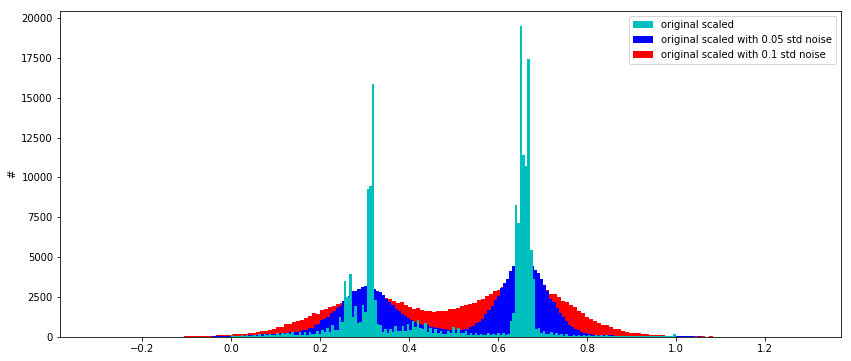

In [3]:
# 1. Load the data into...
image = img.imread('testimg.jpg').flatten()
n_dim, = image.shape
scaled_image = do_scale(image, [0, 1])

# 2. Create two new datasets by adding to the data Gaussian noise...
noisy_scaled_image_05 = add_noise(scaled_image, 0, 0.05)
noisy_scaled_image_1 = add_noise(scaled_image, 0, 0.1)

set_images = [scaled_image,
              noisy_scaled_image_05,
              noisy_scaled_image_1]

set_names = ['original scaled',
             'original scaled with 0.05 std noise',
             'original scaled with 0.1 std noise']

set_colors = ['c', 'b', 'r']

set_orders = [3, 2, 1]

# 3. Create a figure that combines the histograms of all 3 ...
n_bins = int(n_dim/1000)
plt.figure(figsize=(14, 6))
for i in range(3):
    plt.hist(set_images[i], bins=n_bins,
             color=set_colors[i], label=set_names[i], zorder=set_orders[i])
plt.ylabel('#')
plt.legend()
plt.show()


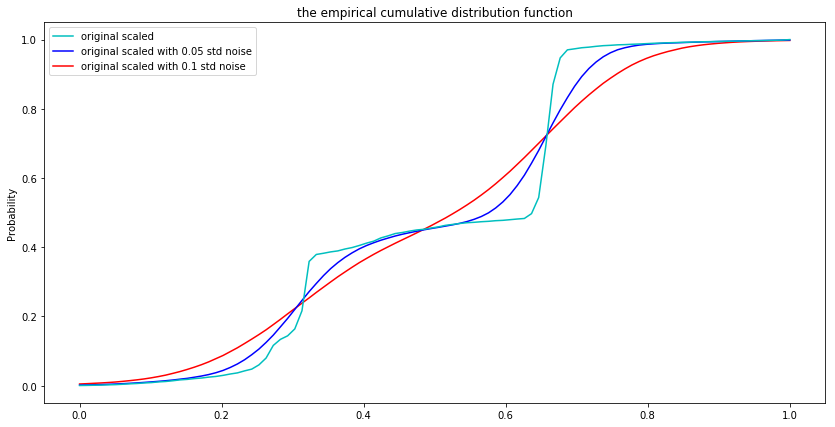

In [4]:
# 4. Create a figure that shows the empirical cumulative distribution functions
n_bins = 100

plt.figure(figsize=(14, 7))
plt.title('the empirical cumulative distribution function')
for i in range(3):
    x_array, p_array = calc_ECDF(set_images[i], n_bins)
    plt.plot(x_array, p_array,
             color=set_colors[i], label=set_names[i], zorder=set_orders[i])
plt.ylabel('Probability')
plt.legend()
plt.show()


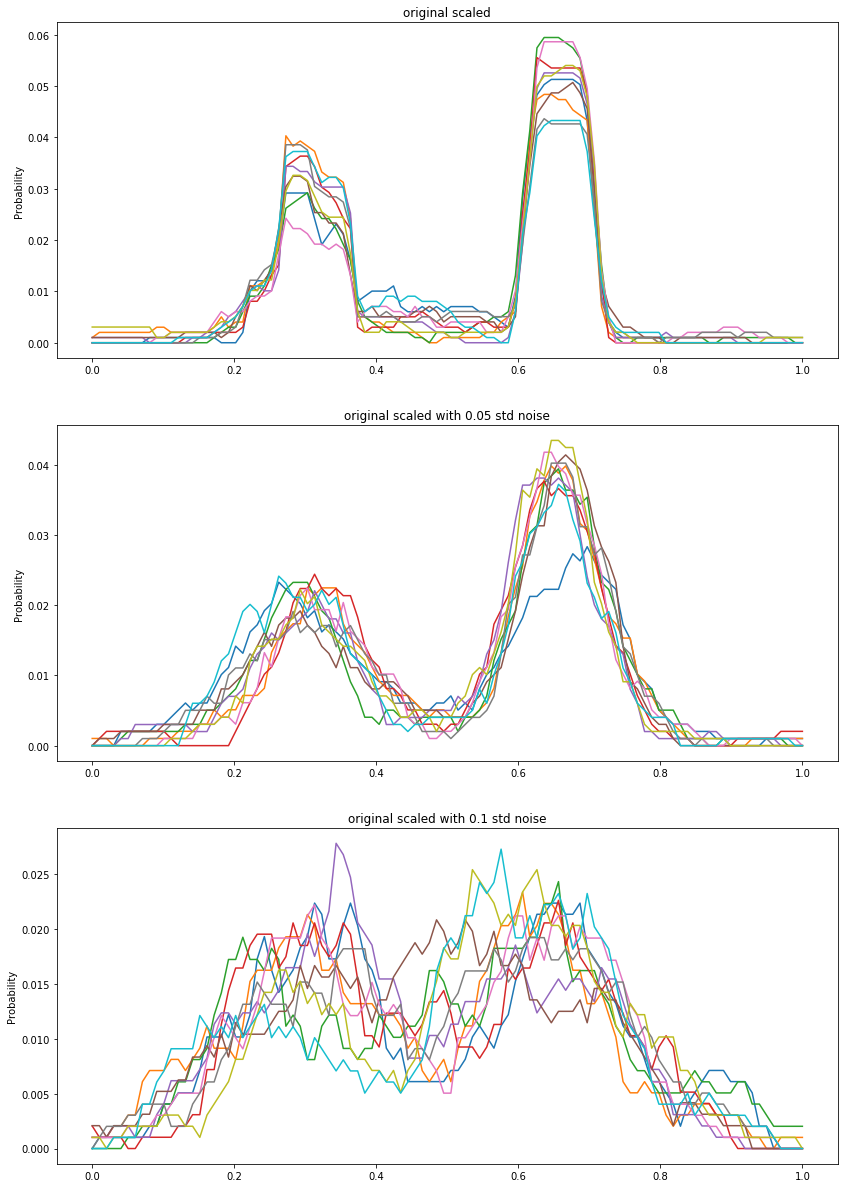

In [5]:
# 5. For each dataset...
n_test = 5000
n_train = 100
n_iter = 10
plt.figure(figsize=(14, 21))
for i, obj_image in enumerate(set_images):
    plt.subplot(3, 1, i+1)
    for v in range(n_iter):
        test_set, train_set = get_sets(obj_image, n_test, n_train)
        x_array, p_array = kde_rect(train_set, 0.1)
        plt.plot(x_array, p_array)
    plt.title(set_names[i])
    plt.ylabel('Probability')
plt.show()

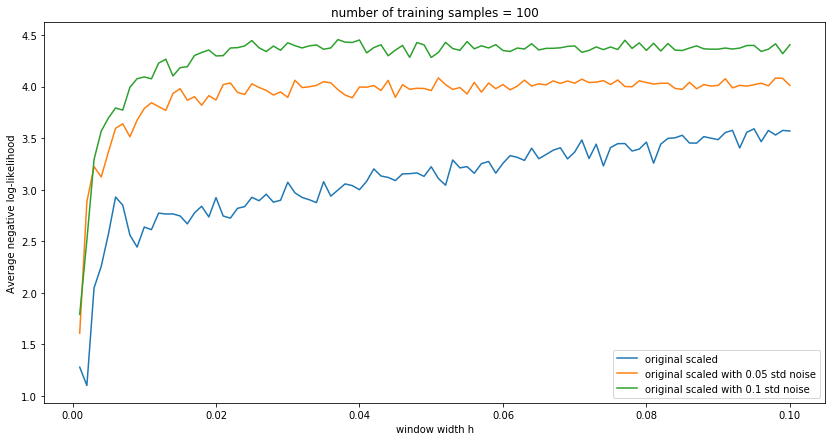

In [6]:
# d) Validation and e) Average negative log-likelihood vs h
h_array = np.linspace(0.001, 0.1, 100, endpoint=True)
n_test = 5000
n_train = 100
n_iter = 1
plt.figure(figsize=(14, 7))
plt.title('number of training samples = {0}'.format(n_train))
for i, obj_image in enumerate(set_images):
    neg_log_like_array = np.zeros_like(h_array)
    for j, h in enumerate(h_array):
        neg_log_like = 0
        for v in range(n_iter):
            test_set, train_set = get_sets(obj_image, n_test, n_train)
            x_array, p_array = kde_rect(train_set, h)
            neg_log_like += -calc_log_like(test_set, x_array, p_array)
        neg_log_like_array[j] = neg_log_like/n_iter
    plt.plot(h_array, neg_log_like_array, label=set_names[i])
    plt.ylabel('Average negative log-likelihood')
    plt.xlabel('window width h')
plt.legend()
plt.show()


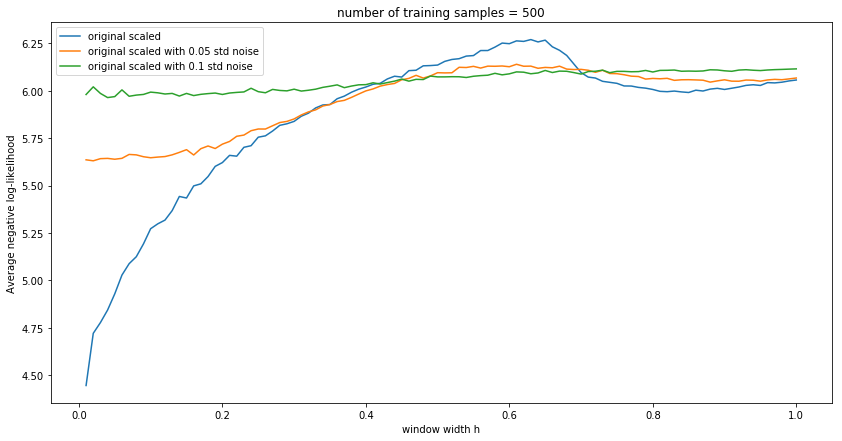

In [7]:
# d) Validation and e) Average negative log-likelihood vs h
h_array = np.linspace(0.01, 1, 100, endpoint=True)
n_test = 5000
n_train = 500
n_iter = 1
plt.figure(figsize=(14, 7))
plt.title('number of training samples = {0}'.format(n_train))
for i, obj_image in enumerate(set_images):
    neg_log_like_array = np.zeros_like(h_array)
    for j, h in enumerate(h_array):
        neg_log_like = 0
        for v in range(n_iter):
            test_set, train_set = get_sets(obj_image, n_test, n_train)
            x_array, p_array = kde_rect(train_set, h)
            neg_log_like += -calc_log_like(test_set, x_array, p_array)
        neg_log_like_array[j] = neg_log_like/n_iter
    plt.plot(h_array, neg_log_like_array, label=set_names[i])
    plt.ylabel('Average negative log-likelihood')
    plt.xlabel('window width h')
plt.legend()
plt.show()


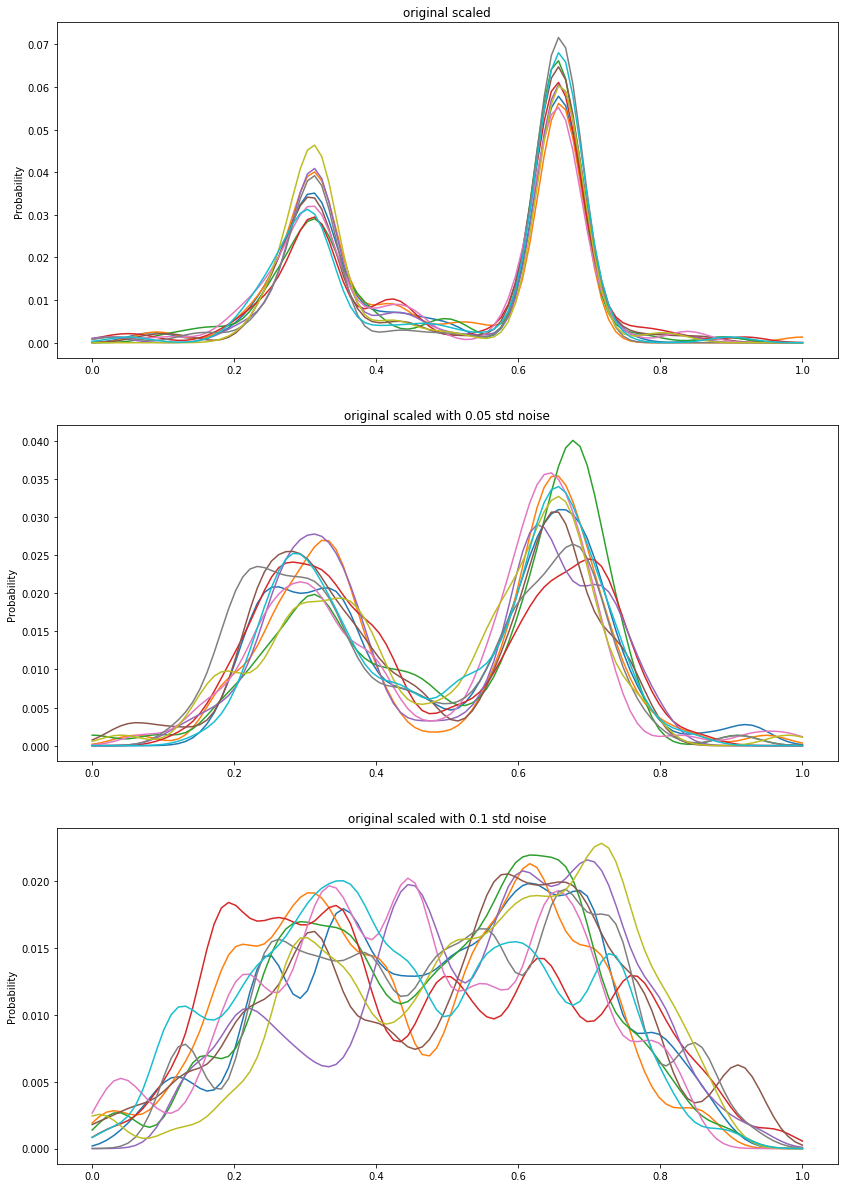

In [8]:
# 5. For gaussian...
n_test = 5000
n_train = 100
n_iter = 10
plt.figure(figsize=(14, 21))
for i, obj_image in enumerate(set_images):
    plt.subplot(3, 1, i+1)
    for v in range(n_iter):
        test_set, train_set = get_sets(obj_image, n_test, n_train)
        x_array, p_array = kde_gaus(train_set, 0.1)
        plt.plot(x_array, p_array)
    plt.title(set_names[i])
    plt.ylabel('Probability')


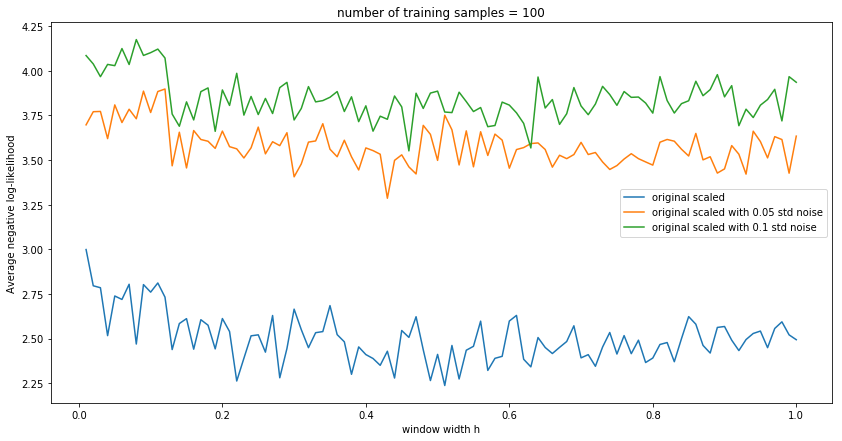

In [9]:
# d) Validation and e) Average negative log-likelihood vs h
h_array = np.linspace(0.01, 1, 100, endpoint=True)
n_test = 5000
n_train = 100
n_iter = 1
plt.figure(figsize=(14, 7))
plt.title('number of training samples = {0}'.format(n_train))
for i, obj_image in enumerate(set_images):
    neg_log_like_array = np.zeros_like(h_array)
    for j, h in enumerate(h_array):
        neg_log_like = 0
        for v in range(n_iter):
            test_set, train_set = get_sets(obj_image, n_test, n_train)
            x_array, p_array = kde_gaus_sp(train_set, h)
            neg_log_like += -calc_log_like(test_set, x_array, p_array)
        neg_log_like_array[j] = neg_log_like/n_iter
    plt.plot(h_array, neg_log_like_array, label=set_names[i])
    plt.ylabel('Average negative log-likelihood')
    plt.xlabel('window width h')
plt.legend()
plt.show()
